<a href="https://colab.research.google.com/github/butchland/fastai_xla_extensions/blob/master/explore_nbs/Explore_fastai_xla_extensions_Pets_TPU_with_batch_tfms.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# FastAI XLA Extensions Pets  Comparison Demo
Same as TPU Comparison except batch_tfms enabled


## How to use

### Configure the Pytorch XLA package 

The Pytorch xla package requires an environment supporting TPUs (Kaggle kernels, GCP or Colab environments required)

If running on Colab, make sure the Runtime Type is set to TPU.


In [1]:
#hide_input
#colab
import os
assert os.environ['COLAB_TPU_ADDR'], 'Make sure to select TPU from Edit > Notebook settings > Hardware accelerator'

In [2]:
#hide
#colab
!curl -s https://course19.fast.ai/setup/colab | bash 

Updating fastai...
Done.


Dont run for GPU

In [3]:
#hide_output
#colab
!pip install -Uqq cloud-tpu-client==0.10 https://storage.googleapis.com/tpu-pytorch/wheels/torch_xla-1.7-cp36-cp36m-linux_x86_64.whl
# VERSION = "20200325"  #@param ["1.5" , "20200325", "nightly"]
# !curl https://raw.githubusercontent.com/pytorch/xla/master/contrib/scripts/env-setup.py -o pytorch-xla-env-setup.py
# !python pytorch-xla-env-setup.py --version $VERSION

     |████████████████████████████████| 133.6MB 80kB/s 
     |████████████████████████████████| 61kB 2.7MB/s 


Install fastai and the fastai_xla_extensions packages

In [4]:
#hide_output
#colab
!pip install -Uqq fastai --upgrade 

In [5]:
#hide_output
#ci
!pip install -Uqq git+https://github.com/butchland/fastai_xla_extensions

In [6]:
!pip freeze | grep torch
!pip freeze | grep fast

torch==1.7.0+cu101
torch-xla==1.7
torchsummary==1.5.1
torchtext==0.3.1
torchvision==0.8.1+cu101
fastai==2.1.9
fastai-xla-extensions==0.0.5
fastcore==1.3.12
fastdtw==0.3.4
fastprogress==1.0.0
fastrlock==0.5


### Import the libraries
Import the fastai and fastai_xla_extensions libraries

In [7]:
from fastai.vision.all import *
import fastai_xla_extensions.core

### Example
Build a Pets classifier - adapted from fastai course [Lesson 5 notebook](https://github.com/fastai/course-v4/blob/master/nbs/05_pet_breeds.ipynb)

Load Oxford-IIT Pets dataset

In [8]:
#colab
path = untar_data(URLs.PETS)/'images'

In [9]:
Path.BASE_PATH = path

In [10]:
pat = r'(.+)_\d+.jpg$'

Create Fastai DataBlock


_Note that batch transforms are currently
set to none as they seem to slow the training
on the TPU (for investigation)._

In [11]:
datablock = DataBlock(
    blocks=(ImageBlock,CategoryBlock),
    get_items=get_image_files,
    splitter=RandomSplitter(seed=42),
    get_y=using_attr(RegexLabeller(pat),'name'),
    item_tfms=Resize(224),
    # batch_tfms=[]
    batch_tfms=aug_transforms(size=224,min_scale=0.75)
)

In [12]:
#colab
datablock.summary(path)

Setting-up type transforms pipelines
Found 7390 items
2 datasets of sizes 5912,1478
Setting up Pipeline: PILBase.create
Setting up Pipeline: partial -> Categorize -- {'vocab': None, 'sort': True, 'add_na': False}

Building one sample
  Pipeline: PILBase.create
    starting from
      /root/.fastai/data/oxford-iiit-pet/images/miniature_pinscher_38.jpg
    applying PILBase.create gives
      PILImage mode=RGB size=500x333
  Pipeline: partial -> Categorize -- {'vocab': None, 'sort': True, 'add_na': False}
    starting from
      /root/.fastai/data/oxford-iiit-pet/images/miniature_pinscher_38.jpg
    applying partial gives
      miniature_pinscher
    applying Categorize -- {'vocab': None, 'sort': True, 'add_na': False} gives
      TensorCategory(26)

Final sample: (PILImage mode=RGB size=500x333, TensorCategory(26))


Found 7390 items
2 datasets of sizes 5912,1478
Setting up Pipeline: PILBase.create
Setting up Pipeline: partial -> Categorize -- {'vocab': None, 'sort': True, 'add_na': Fals

Create the dataloader

In [13]:
dls = datablock.dataloaders(path,bs=256)

In [14]:
#colab
dls.device

device(type='cpu')

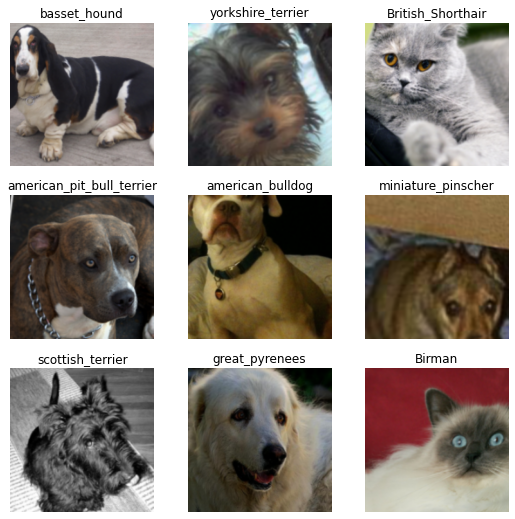

In [15]:
#colab
dls.show_batch()

Create a Fastai CNN Learner

In [16]:
#colab
learner = cnn_learner(dls, resnet34, metrics=accuracy)
                      

Downloading: "https://download.pytorch.org/models/resnet34-333f7ec4.pth" to /root/.cache/torch/hub/checkpoints/resnet34-333f7ec4.pth


Move model to TPU

In [17]:
learner.to_xla()

Using the `lr_find` works 

SuggestedLRs(lr_min=0.014454397559165954, lr_steep=0.002511886414140463)

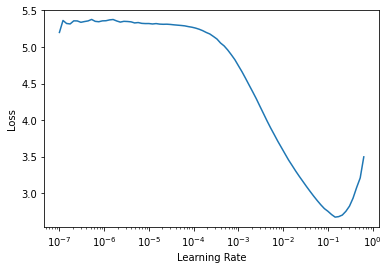

In [18]:
#colab
learner.lr_find()

Fine tune model


In [19]:
%%time
#colab
learner.fine_tune(6,base_lr=9e-3,freeze_epochs=4)

epoch,train_loss,valid_loss,accuracy,time
0,2.555703,0.427116,0.859946,04:09
1,1.311891,0.333248,0.895805,03:17
2,0.844718,0.311840,0.904601,02:50
3,0.612630,0.404002,0.883627,02:51


epoch,train_loss,valid_loss,accuracy,time
0,0.305786,0.447808,0.880244,03:23
1,0.360132,0.807561,0.819350,03:12
2,0.349263,0.632591,0.845061,02:58
3,0.294396,0.507402,0.872124,02:59
4,0.225686,0.351996,0.907984,02:55
5,0.170542,0.335114,0.912720,02:59


CPU times: user 14min 14s, sys: 50.2 s, total: 15min 5s
Wall time: 31min 38s


In [20]:
learner.save('stage-1')

Path('models/stage-1.pth')

Unfreeze the model

In [21]:
#colab
learner.unfreeze()

Run the LR Finder again. 


CPU times: user 3min 25s, sys: 11.1 s, total: 3min 36s
Wall time: 7min 8s


SuggestedLRs(lr_min=2.290867705596611e-05, lr_steep=6.309573450380412e-07)

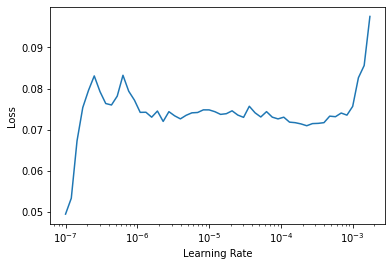

In [22]:
%%time
#colab
learner.lr_find()

Further fine-tuning

In [23]:
%%time
#colab
learner.fit_one_cycle(6,slice(6e-7,2e-5),wd=3e-3)

epoch,train_loss,valid_loss,accuracy,time
0,0.070312,0.333157,0.911367,03:17
1,0.072064,0.334716,0.912043,03:03
2,0.069285,0.322083,0.914073,03:02
3,0.067982,0.322715,0.914073,03:01
4,0.064668,0.319142,0.914750,03:06
5,0.063665,0.325476,0.914073,03:02


CPU times: user 8min 52s, sys: 35.5 s, total: 9min 27s
Wall time: 18min 33s


In [24]:
#hide
#colab
learner.save('stage-2')

Path('models/stage-2.pth')

In [25]:
#hide
#colab
learner.load('stage-2')

Model params are using TPU

In [26]:
#colab
one_param(learner.model).device

device(type='xla', index=1)

Plot loss seems to be working fine.

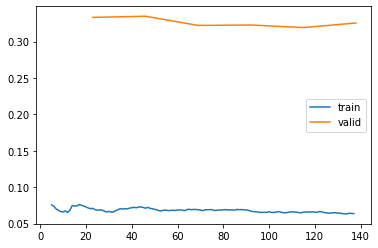

In [27]:
#colab
learner.recorder.plot_loss()

In [28]:
interp = ClassificationInterpretation.from_learner(learner)

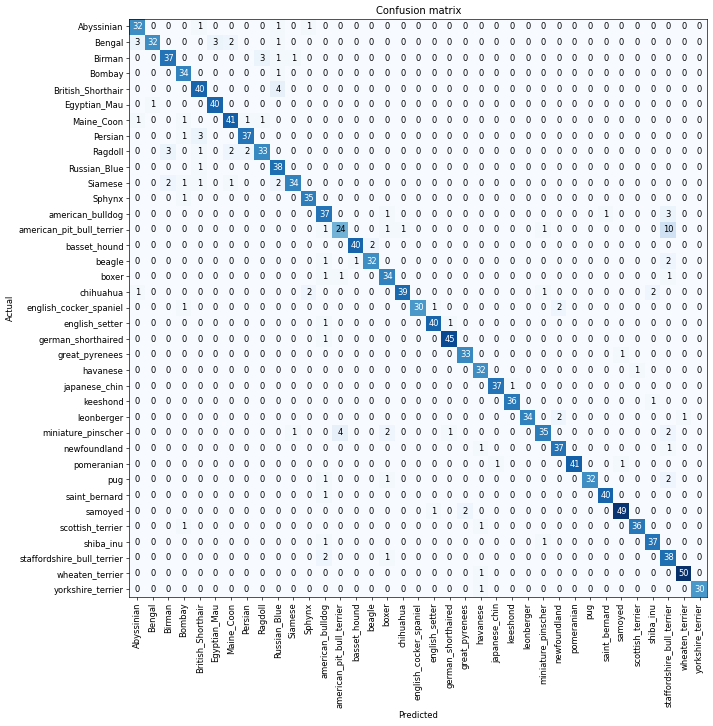

In [29]:
interp.plot_confusion_matrix(figsize=(12,12), dpi=60)

In [30]:
interp.most_confused(4)

[('american_pit_bull_terrier', 'staffordshire_bull_terrier', 10),
 ('British_Shorthair', 'Russian_Blue', 4),
 ('miniature_pinscher', 'american_pit_bull_terrier', 4)]

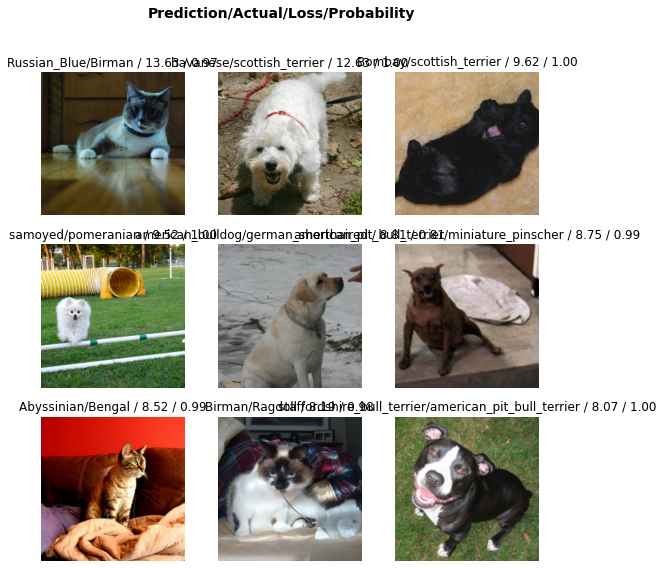

In [31]:
interp.plot_top_losses(9)

In [32]:
# learner.export()

In [33]:
# from google.colab import drive
# drive.mount('/content/drive')

In [34]:
# !mkdir -p /content/drive/MyDrive/fastai_v4/fastai_xla_extensions/pets/models
# !cp /content/models/*.pth /content/drive/MyDrive/fastai_v4/fastai_xla_extensions/pets/models/.
# !cp export.pkl /content/drive/MyDrive/fastai_v4/fastai_xla_extensions/pets/models/.